In [1]:
from pandas import Series, DataFrame
import pandas as pd
import re
import statsmodels.api as sm
from patsy import dmatrices
from copy import deepcopy
from sklearn.cross_validation import train_test_split
from sklearn import neighbors
from sklearn import metrics
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# [Q1 8 points] Read the data. 
Read in the data from http://www.stat.ufl.edu/~winner/data/clinton1.dat. Note that this is NOT a CSV file. The description of the data fields are present in http://www.stat.ufl.edu/~winner/data/clinton1.txt. You will have to figure out the right parameters for the read csv command yourself (e.g., the regular expression for the delimiter, and the names of the columns).

Approach: Read in the data using the read_csv function; set the seperator equal to the regex for two or more spaces in a row to capture each of the data fields accurately.

In [4]:
clinton = pd.read_csv('http://www.stat.ufl.edu/~winner/data/clinton1.dat', sep=r'\s{2,}', names = ['CountyName', 'percentVoting', 'MedianAge', 'MeanSavings', 'PerCapitaIncome', 'Poverty', 'Veterans', 'Female', 'PopDensity', 'NursingHomes', 'CrimeIndex'], engine = 'python')
clinton

,CountyName,percentVoting,MedianAge,MeanSavings,PerCapitaIncome,Poverty,Veterans,Female,PopDensity,NursingHomes,CrimeIndex
0,"Autauga, AL",30.92,31.7,57623,15768,15.2,10.74,51.41,60.4,2.36,457
1,"Baldwin, AL",26.24,35.5,84935,16954,13.6,9.73,51.34,66.5,5.40,282
2,"Barbour, AL",46.36,32.8,83656,15532,25.0,8.82,53.03,28.8,7.02,47
3,"Blount, AL",32.92,34.5,61249,14820,15.0,9.67,51.15,62.4,2.36,185
4,"Bullock, AL",67.67,31.7,75725,11120,33.0,7.08,50.76,17.6,2.91,141
5,"Butler, AL",47.43,33.5,75887,12015,27.1,9.48,53.25,28.1,7.98,266
6,"Calhoun, AL",38.44,32.7,76073,15162,18.0,11.95,51.66,190.8,4.81,560
7,"Chambers, AL",45.36,34.8,40498,13887,18.8,10.52,52.77,62.1,6.15,218
8,"Cherokee, AL",53.61,36.3,56386,13936,15.4,9.29,50.82,35.8,5.61,51
9,"Chilton, AL",34.19,34.0,52230,14036,18.6,9.48,51.41,47.8,3.58,296


# [Q2 8 points] Predict percentVoting on all regressors. 
One of the fields in the data is “Percent voting for Clinton in 1992”; let’s call it percentVoting. Regress percentVoting on all available regressors. Which two regressors have the worst p-values?

Approach: Regress percentVoting on all the regressors using the design matrix and OLS functions. Get the p-values from the result object, sort them from highest to lowest (a high p-value is bad) and return the top two values.

In [5]:
y, X = dmatrices('percentVoting ~ MedianAge + MeanSavings + PerCapitaIncome + Poverty + Veterans + Female + PopDensity + NursingHomes+CrimeIndex', data=clinton, return_type='dataframe')
model = sm.OLS(y, X)
result = model.fit()
print 'Below are the two regressors with the worst (highest) p-values:'
print result.pvalues.sort_values(ascending=False)[:2]

Below are the two regressors with the worst (highest) p-values:
MedianAge     0.238619
CrimeIndex    0.141950
dtype: float64


# [Q3 8 points] A formula-creating function. 
Write a function called formula that takes a list of regressors as input, and outputs the formula for regressing percentVoting on these regressors.
For example, formula([’age’, ’savings’]) should output percentVoting ∼ age + savings.

Approach: Define a function that will return a formula from a list; the function will add each regressor in the list in sequence to the formula string output.

In [6]:
# define function to take regressors and output function
def formula(regress_list):
    regressor_string = 'percentVoting ~'
    if len(regress_list) == 1:
        for regressor in regress_list:
            regressor_string += " " + regressor
        return regressor_string
    else:
        regressor_string = 'percentVoting ~ ' + regress_list[0]
        for regressor in regress_list[1:]:
            regressor_string += " + " + regressor
        return regressor_string

# test the function
formula(['MedianAge', 'MeanSavings'])

'percentVoting ~ MedianAge + MeanSavings'

# [Q4 8 points] R-squared computation function. 
Write a function called rsquared that, given a list of regressors, returns the R-squared corresponding to a regression of percentVoting with respect to the list of regressors. You can use the formula function you wrote above.

Approach: Define a function that will take a list of regressors, use the formukla function to get a formula string, and then run a regression using the formula string. From the result object created in the regression, get the r-squared value.

In [7]:
# define function to get r-squared computation
def rsquared(regress_list):
    regressor_string = formula(regress_list)
    y, X = dmatrices(regressor_string, data=clinton, return_type='dataframe')
    model = sm.OLS(y, X)
    result = model.fit()
    r_square = result.rsquared
    return r_square

# test the function
rsquared(['MedianAge', 'MeanSavings', 'Veterans'])

0.024086938536483693

# [Q5 8 points] Find the next best regressor. 
Write a function called best next regressor that, given a list of regressors (called current regressor list) and the list of all possible regressors (called all regressors list), picks one regressor from all regressors list that, when combined with the regressors in current regressor list, yields the highest R-square. The function should return this regressor, and the corresponding R-square.

Approach: Define a function that will return the next best regressor from a list of available regressors, based on a list of current regressors. Create a dictionary for the regressors and the r-squared values that correspond to that regressor. For all regressors in the available regressor list that are not already in the current regressor list, add that value to the regressor list and then run the list through the rsquared function above. Add the regressor and its r-squared value to the r-squared dictionary. Set the regressor list back to the values originally provided. Once all available regressors have been added to the r-squared dictionary, convert the dictionary to a series and get the maximum value (r-squared value) and its index(regressor).

In [8]:
# define fucntion to get best next regressor
def next_best_regressor(current_regressor_list, all_regressor_list):
    r_squared_dict = {}
    regressor_list = deepcopy(current_regressor_list)
    list_len = len(regressor_list)
    for regressor in all_regressor_list:
        if regressor not in current_regressor_list:
            regressor_list.append(regressor)
            r_squared = rsquared(regressor_list)
            r_squared_dict[regressor] = r_squared
            regressor_list = regressor_list[:list_len]
    regressor_series = Series(r_squared_dict.values(), index=r_squared_dict.keys())
    return regressor_series.idxmax(), regressor_series.max()

# test the function
regressor, r_sqr = next_best_regressor(['MedianAge', 'MeanSavings'], ['MedianAge', 'MeanSavings', 'Poverty', 'Veterans'])
print 'The next best regressor is', regressor, 'with an r-squared of', format(r_sqr, '.4f')

The next best regressor is Poverty with an r-squared of 0.2537


# [Q6 8 points] Pick the k best regressors. 
Write a function called best regressors that takes two arguments:
1. num regressors, which is the number of regressors we want, and
2. all regressors list, which again is the list of all possible regressors.

The function should compute the best num regressors regressors by picking them one at a time using best next regressor that you wrote above. The function should return a tuple of the following items:
1. a list of the best regressors, in the order in which they were picked, and
2. the corresponding R-square values.

In other words, you want a list of the results of calling best next regressor.

Approach: Define function to take number of best regressors and a list of available regressors. Initialize lists to be used in the function, and set initialize the output tuple. Run the current list and the all regressors lists through the next best regressors function; add the returned regressor to the current list to be used in future iterations. Add the returned regressor and its r-squared value to the lists for the output tuple. Iterate through these previous steps for the desired number of regressors.

In [9]:
# define function to pick k best regressors
def best_regressors(num_regressors, all_regressors_list):
    current_list = []
    output_regress_list = []
    output_r_sqr_list = []
    output_tuple = (output_regress_list, output_r_sqr_list)
    for num in range(num_regressors):
        regressor, r_sqr = next_best_regressor(current_list, all_regressors_list)
        current_list.append(regressor)
        output_regress_list.append(str(regressor))
        output_r_sqr_list.append(float(format(r_sqr, '.4f')))
    return output_tuple
        
# test the function
best_regressors(2,['MedianAge', 'MeanSavings', 'Poverty', 'Veterans'])

(['Poverty', 'Veterans'], [0.251, 0.253])

# [Q7 8 points] Order all regressors in the best order. 
Run best regressors to output all available regressors in sequence. In other words, the first item
in the result should be the best single regressor, the second item should be
the next best regressor that combined with the first regressor gives the best R-square, and so on.
This idea of ordering the regressors in this particular order is called forward selection, and is one way of selecting only a few regressors when given a large set of regressors.

Approach: Run all regressors through the best regressors function and get the output tuple of the regressors in order and the correspondign r-squared value with each additional regressor.

In [10]:
# run the best regressors function on all the available regressors
best_regress = best_regressors(9, ['MedianAge', 'MeanSavings', 'PerCapitaIncome', 'Poverty', 'Veterans', 'Female', 'PopDensity', 'NursingHomes', 'CrimeIndex'])
best_regress

(['Poverty',
  'PopDensity',
  'Female',
  'MeanSavings',
  'Veterans',
  'NursingHomes',
  'PerCapitaIncome',
  'CrimeIndex',
  'MedianAge'],
 [0.251, 0.2858, 0.3091, 0.3192, 0.323, 0.3249, 0.3258, 0.3266, 0.3269])

# [Q8 8 points] Plot the R-squared values as regressors are added in the best order.

Approach: Using the output tuple from the previous problem, create a dataframe with the r-squared values as the values and the regressors as the index. Plot the dataframe to display r-squared increase with each regressor.

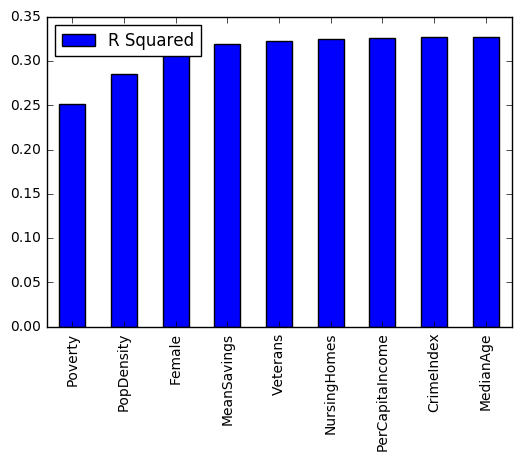

In [11]:
regress_df = pd.DataFrame(best_regress[1], index=best_regress[0])
regress_df.columns = ['R Squared']
regress_df.plot(kind='bar')

# K-Nearest Neighbors Classification

# [Q9 8 points] Create a classification target. 
Attach a new column, called target to the DataFrame, whose value for each row is either 1 (if percentVoting is at least 40.0), or 0 (percentVoting is less than 40.0).

Approach: Set a new column, "Target", equal to 0. Mask the dataframe for only those instances where percentVoting is greater than 40. Set the value for the "Target" column to 1 for these instances.

In [12]:
clinton['Target'] = 0
percent_mask = clinton['percentVoting'] >= 40
clinton.ix[percent_mask, 'Target'] = 1
clinton

,CountyName,percentVoting,MedianAge,MeanSavings,PerCapitaIncome,Poverty,Veterans,Female,PopDensity,NursingHomes,CrimeIndex,Target
0,"Autauga, AL",30.92,31.7,57623,15768,15.2,10.74,51.41,60.4,2.36,457,0
1,"Baldwin, AL",26.24,35.5,84935,16954,13.6,9.73,51.34,66.5,5.40,282,0
2,"Barbour, AL",46.36,32.8,83656,15532,25.0,8.82,53.03,28.8,7.02,47,1
3,"Blount, AL",32.92,34.5,61249,14820,15.0,9.67,51.15,62.4,2.36,185,0
4,"Bullock, AL",67.67,31.7,75725,11120,33.0,7.08,50.76,17.6,2.91,141,1
5,"Butler, AL",47.43,33.5,75887,12015,27.1,9.48,53.25,28.1,7.98,266,1
6,"Calhoun, AL",38.44,32.7,76073,15162,18.0,11.95,51.66,190.8,4.81,560,0
7,"Chambers, AL",45.36,34.8,40498,13887,18.8,10.52,52.77,62.1,6.15,218,1
8,"Cherokee, AL",53.61,36.3,56386,13936,15.4,9.29,50.82,35.8,5.61,51,1
9,"Chilton, AL",34.19,34.0,52230,14036,18.6,9.48,51.41,47.8,3.58,296,0


# [Q10 8 points] Create training and test sets. 
Create design matrices for predicting the target using just the two features poverty and popdensity. Split this into design matrices for training and testing datasets, with 70% data being used for training, and 30% for testing.

Approach: Create the design matrix for the prediction method, predicting Target from Poverty and PopDensity. Using the train_test_split function, divide the dataset into training and testing datasets.

In [13]:
# call the formula function to create design matrix
y, X = dmatrices('Target ~ Poverty + PopDensity', data=clinton, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# [Q11 12 points] Accuracy of classification. 
Use a K-nearest neighbors classifier to predict the target using the two given features, using 1, 3, 5, 10, 20, 50, 100, and 1000 nearest neighbors respectively. Print out the training and test accuracy for each of these.

Approach: Set the neighbor list equal to the desired number of neighbors. For the desired number of different neighbors, iterate the following steps. Set the model using a KNeighborsClassifier function, setting the number of neighbors equal to the amount specified by the neighbor list. Print the number of neighbors used for the model. Predict the model on the training data. Print the training accuracy by getting the accuracy score from metrics on the y-training set and the model derived from the x training set. Print the testing accuracy by getting the accuracy score from metrics on the y testing set and the model derived from the x training set.

In [14]:
neighbor_list = [1,3,5,10,20,50,1000]

for neighbor_num in neighbor_list:
    model = neighbors.KNeighborsClassifier(n_neighbors=neighbor_num,
                                       weights='uniform',
                                       p=2)
    
    print 'Number of Neighbors:', neighbor_num
    model.fit(X_train, y_train)
    prediction_on_training = model.predict(X_train)
    print 'Train accuracy:', metrics.accuracy_score(y_train, prediction_on_training)
    prediction_on_test = model.predict(X_test)
    print 'Test accuracy:', metrics.accuracy_score(y_test, prediction_on_test)
    print ''

Number of Neighbors: 1
Train accuracy: 0.997885835095
Test accuracy: 0.600985221675

Number of Neighbors: 3
Train accuracy: 0.788054968288
Test accuracy: 0.635467980296

Number of Neighbors: 5
Train accuracy: 0.748414376321
Test accuracy: 0.630541871921

Number of Neighbors: 10
Train accuracy: 0.720401691332
Test accuracy: 0.646551724138

Number of Neighbors: 20
Train accuracy: 0.690274841438
Test accuracy: 0.658866995074

Number of Neighbors: 50
Train accuracy: 0.683932346723
Test accuracy: 0.662561576355

Number of Neighbors: 1000


/Users/juan.fuentes/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/juan.fuentes/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/juan.fuentes/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/juan.fuentes/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/juan.fuentes/anaconda/lib/python2.7/site-

Train accuracy: 0.567124735729
Test accuracy: 0.576354679803



# [Q12 8 points] Plots and reasons. 
Show a scatter plot of popdensity versus poverty, and color the points according to the target (i.e., each point in the scatter plot represents a county, and the color of the county depends on the value of target for that county). Can you interpret the plot? What types of counties voted for Bill Clinton?

Approach: Create a scatter plot based on the x training set, divided the axes into the Poverty and PopDensity regressors. Set the color to differ based on instance of being in the target (above 40% voting) and out of the target.

The graph is clustered, but most of the blue dots (not in the target of >40% voting for Clinton)
can be found in very low population densities.


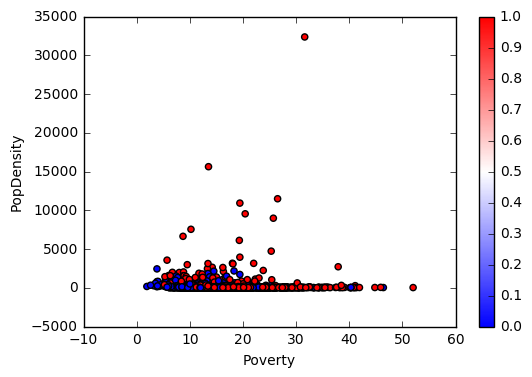

In [15]:
sc = scatter(X_train['Poverty'], X_train['PopDensity'], c=y_train, cmap='bwr')
colorbar(sc)
xlabel('Poverty')
ylabel('PopDensity')
print 'The graph is clustered, but most of the blue dots (not in the target of >40% voting for Clinton)\n\
can be found in very low population densities.'